In [25]:
# %pip install torch
# %pip install pymoo
# %pip install pywin32

In [26]:
import os, sys

# Get the absolute path of the notebook's directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add the parent directory to sys.path so we can import modules
sys.path.append(parent_dir)

# Verify the path
print(f"Added to sys.path: {parent_dir}")

# Add it to sys.path
sys.path.append(parent_dir)

print(parent_dir)
from localityaware.module import *
from NSGA_nn.nsga import *
from Vinyl_Distillation.VCDistillationDummy import *

Added to sys.path: /Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen
/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen


In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import time

# Define the file path for saving/loading the data
data_file = "vcdistil.pkl"



print("Generating new data...")
assSim = VCDistillationDummy(AspenFile="Vinyl Chloride Distillation.bkp", 
                        wdpath="../Vinyl_Distillation", 
                        visibility=False)

Generating new data...
Dummy mode: Initialized distillation column simulation. No Aspen calls will be made.


In [28]:
import numpy as np
import time
from scipy.stats import qmc

# Number of samples you want to generate
N = 100  # change this as needed

# Define lower and upper bounds for the 8 parameters
lower_bounds = np.array([
    30,    # trays low
    2,     # feed position low
    0.1,   # reflux ratio low
    0.46,  # distillate-to-feed ratio low
    35,    # trays high
    2,     # feed position high
    0.1,   # reflux ratio high
    0.89   # distillate-to-feed ratio high
])

upper_bounds = np.array([
    36,    # trays low
    29,    # feed position low
    1.5,   # reflux ratio low
    0.48,  # distillate-to-feed ratio low
    42,    # trays high
    34,    # feed position high
    1.5,   # reflux ratio high
    0.91   # distillate-to-feed ratio high
])


# Initialize the Latin Hypercube sampler for 8 dimensions
sampler = qmc.LatinHypercube(d=8)
sample_unit = sampler.random(n=N)  # Samples in [0, 1) with shape (N,8)

# Scale the samples to the desired parameter ranges
samples_scaled = qmc.scale(sample_unit, lower_bounds, upper_bounds)

# print("samples_scaled", samples_scaled)

# For integer parameters, round the values.
# We assume indices 0, 1, 4, and 5 are integers.
samples_scaled[:, 0] = np.round(samples_scaled[:, 0]).astype(int)
samples_scaled[:, 1] = np.round(samples_scaled[:, 1]).astype(int)
samples_scaled[:, 4] = np.round(samples_scaled[:, 4]).astype(int)
samples_scaled[:, 5] = np.round(samples_scaled[:, 5]).astype(int)

# For debugging: print the first few samples
print("First 5 LHS samples (each row corresponds to [trays low, feed low, reflux low, dist-feed low, trays high, feed high, reflux high, dist-feed high]):")
print(samples_scaled[:5])

First 5 LHS samples (each row corresponds to [trays low, feed low, reflux low, dist-feed low, trays high, feed high, reflux high, dist-feed high]):
[[30.          6.          0.76000646  0.4600376  35.         26.
   0.81017683  0.89556087]
 [33.         11.          0.47735712  0.46870678 40.         11.
   0.50255475  0.8972919 ]
 [31.         12.          0.29927087  0.46774716 39.         21.
   1.14156264  0.90145633]
 [31.         22.          0.41117266  0.47406532 38.         19.
   1.17942688  0.89810421]
 [34.         25.          0.20707762  0.46038694 35.         28.
   0.31493097  0.90812582]]


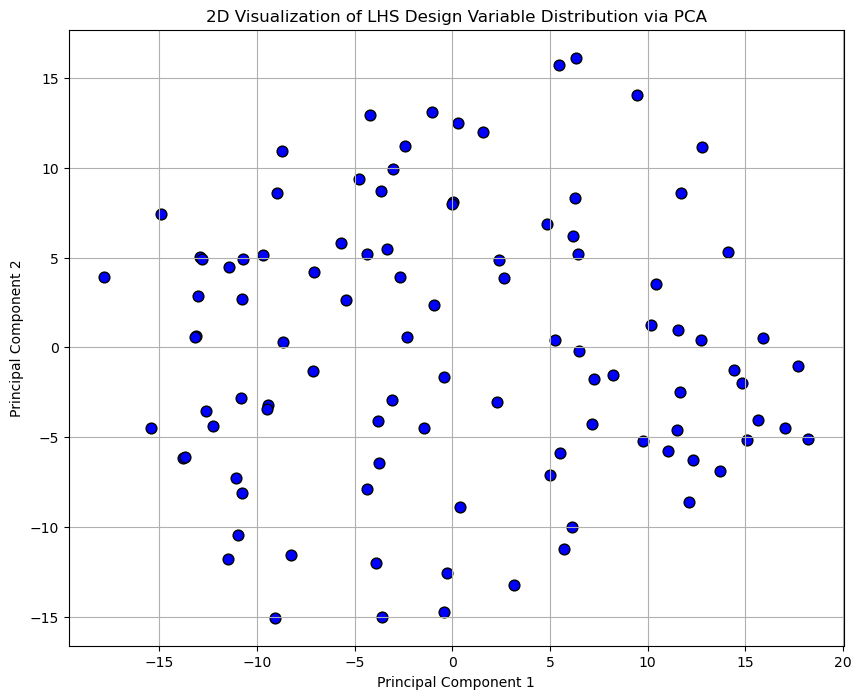

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Here, we assume samples_scaled is a NumPy array with shape (N, 8)
# representing your 8 design variables from LHS.
X_params = samples_scaled[:, :8]

# Apply PCA to reduce the 8-dimensional parameter space to 2 dimensions.
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_params)

# Create a scatter plot for the reduced parameters.
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='blue', edgecolor='k', s=60)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of LHS Design Variable Distribution via PCA')
plt.grid(True)
plt.show()


In [30]:
# Start timing the data generation (simulation evaluations)
start_time = time.time()

data_sim = []

for param_array in samples_scaled:
    # Convert the 8 parameters into the expected input format
    x_unflat = assSim.unflatten_params(param_array)
    # Run the objective function (this is where the Aspen or dummy simulation is called)
    cost = assSim.run_obj(x_unflat)
    # Save the parameters and cost together; you can store as [p1, p2, ..., p8, cost]
    # print(cost)
    data_sim.append(list(param_array) + list(cost))
print(data_sim[:2])

flat_array: [30.          6.          0.76000646  0.4600376  35.         26.
  0.81017683  0.89556087]
flat_array: [33.         11.          0.47735712  0.46870678 40.         11.
  0.50255475  0.8972919 ]
flat_array: [31.         12.          0.29927087  0.46774716 39.         21.
  1.14156264  0.90145633]
flat_array: [31.         22.          0.41117266  0.47406532 38.         19.
  1.17942688  0.89810421]
flat_array: [34.         25.          0.20707762  0.46038694 35.         28.
  0.31493097  0.90812582]
flat_array: [31.          8.          0.92399824  0.46853201 40.         30.
  0.91511931  0.90305853]
flat_array: [30.         12.          0.58799512  0.46921305 39.         17.
  0.89409563  0.89903485]
flat_array: [33.         17.          0.73080429  0.46624259 36.         29.
  0.58275205  0.90491057]
flat_array: [36.         29.          0.71737892  0.4764703  37.         17.
  1.38289013  0.89716293]
flat_array: [33.          4.          0.17256734  0.47271575 42.         

In [31]:
data_sim = np.array(data_sim)
elapsed = time.time() - start_time
print(f"Generated {len(data_sim)} simulation points in {elapsed:.2f} seconds.")

# Save the dataset if needed (for example, to a pickle file)
import pickle
with open("distillation_data_sim.pkl", "wb") as f:
    pickle.dump({"data": data_sim, "time_sec": elapsed}, f)

data_sim = np.array(data_sim)
data_gen_time = time.time() - start_time  # Total time to generate data
total_original_assSim_calls = len(data_sim)

Generated 100 simulation points in 0.01 seconds.


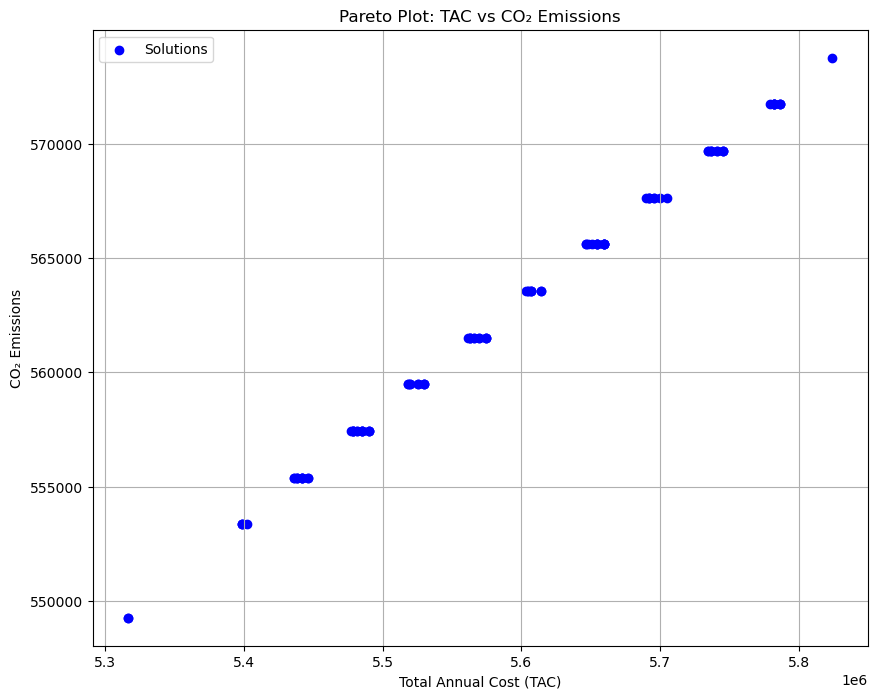

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# For demonstration purposes, assume you have an array of objectives
# with shape (N, 2) where each row is [TAC, CO₂ Emissions].
# Replace this with your actual data.
objectives = data_sim[:, -2:]  # Assuming the last two columns are the objectives
plt.figure(figsize=(10, 8))
plt.scatter(objectives[:, 0], objectives[:, 1], color='blue', marker='o', label="Solutions")
plt.xlabel('Total Annual Cost (TAC)')
plt.ylabel('CO₂ Emissions')
plt.title('Pareto Plot: TAC vs CO₂ Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
print(len(data_sim))

# Instantiate the scaler with your provided ranges for 8-D inputs and 2-D outputs.
scaler = TorchMinMaxScaler(
    feature_range=(-1, 1), 
    max_vals=[36, 29, 1.5, 0.48, 42, 34, 1.5, 0.91],  # maximum for each of the 8 input parameters
    min_vals=[30, 2, 0.1, 0.46, 35, 2, 0.1, 0.89],       # minimum for each of the 8 inputs
    scale_y=True,
    min_y=[1e5, 1e4],   # minimum for the 2 outputs (e.g., TAC and CO₂)
    max_y=[1e6, 1e5]    # maximum for the 2 outputs
)

# Correct: use data_sim[:, :8] for inputs, and data_sim[:, 8:] for outputs.
data_sim_xscaled, data_sim_yscaled = scaler.transform(data_sim[:, :8], data_sim[:, 8:])

# Convert the PyTorch tensors to NumPy arrays.
data_sim_xscaled = data_sim_xscaled.detach().cpu().numpy()
data_sim_yscaled = data_sim_yscaled.detach().cpu().numpy()

# Check shapes for debugging:
print("Shape of scaled inputs:", data_sim_xscaled.shape)   # should be (N, 8)
print("Shape of scaled outputs:", data_sim_yscaled.shape)    # should be (N, 2)

# Recombine scaled inputs and outputs into one array with 10 columns (8 + 2).
data_sim_scaled = np.column_stack([data_sim_xscaled, data_sim_yscaled])
print("Shape of combined scaled data:", data_sim_scaled.shape)


# **Initialize Model & Dataset**
dataset = DynamicDataset(data_sim_scaled, num_inputs=8)
model = MLP(8, [50, 50, 20, 20, 50, 50], 2)

print("Dataset and model initialized.")

100
Shape of scaled inputs: (100, 8)
Shape of scaled outputs: (100, 2)
Shape of combined scaled data: (100, 10)
Dataset and model initialized.


In [34]:
from VCDistillationDummy import VinylDistillationProblem
problem = VinylDistillationProblem(model)

In [35]:
out = optimize_surr_nsga(model=model,
                   dataset=dataset,
                   assSim=assSim,
                   problem=problem,
                   lrs={'first':1e-3, 'others':1e-3},
                   epochs={'first':200, 'others':200},
                   min_vals=scaler.min_x,
                   max_vals=scaler.max_x,
                   scaler=scaler,
                   device='cpu',
                   iter=5,
                   print_loss=True,
                   print_it_data=True,
                   pop_size=100,
                   n_gen = 5,
                   new_data_size=5,
                   batch_size=25
                   )

Iteration 0: Training surrogate model...
Epoch 0: Total Loss=126.5695
Epoch 50: Total Loss=41.8338
Epoch 100: Total Loss=2.7864


/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([100, 1, 2])) that is different to the input size (torch.Size([100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 150: Total Loss=1.2488
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  0.000000E+00 |             f
     3 |      300 |      1 |  0.5816326141 |         ideal
     4 |      400 |      1 |  0.5859513283 |         ideal
     5 |      500 |      1 |  0.4763827324 |         ideal
optim_input_scaled.shape: (1, 8)
optim_input.shape: (1, 8)
flat_array: [32.98562    13.763654    0.82948214  0.46942747 38.707157   17.068367
  0.84549564  0.90222263]
Evaluated samples shape: (1, 10)
flat_array: tensor([33.0657, 16.5986,  0.6627,  0.4751, 37.2294, 16.2555,  0.9283,  0.8997])
flat_array: tensor([33.9671, 18.6538,  1.1793,  0.4701, 38.0368, 11.2184,  0.4729,  0.8965])
flat_array: tensor([32.0793, 18.7268,  1.3807,  0.4718, 38.7712,  8.7617,  0.9422,  0.9023])
flat_array: tensor([32.3462, 18.4534,  0.9905,  0.4722, 37.2258, 21.5141,  0.1434,  0.9061])
flat_array: tensor([35.1394, 21.8999,  0.871

/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([106, 1, 2])) that is different to the input size (torch.Size([106, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50: Total Loss=0.0882
Epoch 100: Total Loss=0.0567
Epoch 150: Total Loss=0.0508
Using previous population of size 100
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  0.2125759125 |         ideal
     3 |      300 |      1 |  0.0194969177 |         ideal
     4 |      400 |      1 |  0.1058206558 |         ideal
     5 |      500 |      1 |  0.0513629913 |         ideal
optim_input_scaled.shape: (1, 8)
optim_input.shape: (1, 8)
flat_array: [32.59282    13.759453    0.82948214  0.46971026 39.29036    17.12061
  0.944468    0.894227  ]
Evaluated samples shape: (1, 10)
flat_array: tensor([32.5049, 17.8675,  0.8588,  0.4699, 38.6491, 21.1415,  0.8412,  0.8956])
flat_array: tensor([33.0326, 13.9051,  0.8302,  0.4695, 38.7151, 20.1270,  1.0500,  0.8956])
flat_array: tensor([32.5359, 19.9329,  0.6590,  0.4701, 38.7149, 19.6835,  0.8165,  0.8972])
flat_array: tensor([32.9891, 13.4830,  0.82

/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([112, 1, 2])) that is different to the input size (torch.Size([112, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50: Total Loss=0.0464
Epoch 100: Total Loss=0.0441
Epoch 150: Total Loss=0.0434
Using previous population of size 100
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  0.000000E+00 |             f
     3 |      300 |      1 |  0.0098829269 |         ideal
     4 |      400 |      1 |  0.0070676804 |         ideal
     5 |      500 |      1 |  0.0316457748 |         ideal
optim_input_scaled.shape: (1, 8)
optim_input.shape: (1, 8)
flat_array: [33.222534   16.397678    0.86513186  0.4713536  38.66146    16.896585
  0.81614465  0.8991869 ]
Evaluated samples shape: (1, 10)
flat_array: tensor([33.0243, 14.0814,  0.8559,  0.4700, 38.7043, 17.8172,  0.8609,  0.8997])
flat_array: tensor([32.9842, 14.1440,  0.7978,  0.4745, 39.1722, 13.6150,  0.7343,  0.8995])
flat_array: tensor([33.0940, 16.4254,  0.8287,  0.4695, 38.7501, 16.8753,  0.5998,  0.8997])
flat_array: tensor([33.2575, 16.6294,  0.8

/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([118, 1, 2])) that is different to the input size (torch.Size([118, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50: Total Loss=0.0437
Epoch 100: Total Loss=0.0409
Epoch 150: Total Loss=0.0407
Using previous population of size 100
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  0.0000196605 |             f
     3 |      300 |      1 |  0.0011143308 |             f
     4 |      400 |      2 |  1.1331834785 |         ideal
     5 |      500 |      1 |  0.0026178360 |         ideal
optim_input_scaled.shape: (1, 8)
optim_input.shape: (1, 8)
flat_array: [33.222534   16.397678    0.8647835   0.4714534  38.66146    16.896585
  0.81614465  0.89874625]
Evaluated samples shape: (1, 10)
flat_array: tensor([33.2316, 15.6215,  0.8648,  0.4714, 38.6615, 16.8966,  0.8163,  0.8992])
flat_array: tensor([32.9529, 16.3977,  0.8648,  0.4714, 38.6589, 16.8966,  0.8161,  0.8992])
flat_array: tensor([33.2225, 16.3977,  0.8648,  0.4714, 38.6615, 16.8966,  0.8161,  0.8992])
flat_array: tensor([33.2225, 16.3977,  0.8

/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([124, 1, 2])) that is different to the input size (torch.Size([124, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50: Total Loss=0.0410
Epoch 100: Total Loss=0.0386
Epoch 150: Total Loss=0.0385
Using previous population of size 100
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  0.0033349991 |         ideal
     3 |      300 |      1 |  0.0120973587 |         ideal
     4 |      400 |      1 |  0.0128927231 |         ideal
     5 |      500 |      1 |  0.0093107224 |         ideal
optim_input_scaled.shape: (1, 8)
optim_input.shape: (1, 8)
flat_array: [32.984234   13.562782    0.5135947   0.47524336 39.172634   14.032007
  0.73429936  0.89511985]
Evaluated samples shape: (1, 10)
flat_array: tensor([33.0998, 14.2560,  0.7975,  0.4746, 39.1722, 14.0871,  0.7350,  0.8951])
flat_array: tensor([33.4350, 13.6279,  0.6910,  0.4746, 39.5840, 17.0830,  0.8444,  0.8950])
flat_array: tensor([32.9842, 14.1933,  0.7514,  0.4795, 39.1722, 11.3898,  0.7343,  0.8951])
flat_array: tensor([33.1019, 14.7829,  0.7

In [36]:
import os
import datetime
import pickle

print(os.getcwd())
# Get current notebook name manually (or hardcode it here)
notebook_name = "vinyl"  # or os.path.basename(__file__).replace(".py", "")

# Get timestamp
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Construct path: results/<notebook_name>/run_<timestamp>/
base_dir = os.path.join("../NSGA_nn/results", notebook_name)
save_dir = os.path.join(base_dir, f"run_{now}")
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

print(f"Results will be saved in: {save_dir}")

# Save out.pkl
out["data_gen_time"] = data_gen_time
out["total_original_assSim_calls"] = total_original_assSim_calls
with open(os.path.join(save_dir, "out.pkl"), "wb") as f:
    pickle.dump(out, f)

# Save scaler
with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# Save dataset
with open(os.path.join(save_dir, "dataset.pkl"), "wb") as f:
    pickle.dump(dataset, f)

print(f"Saved all results in {save_dir}")


/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen/Vinyl_Distillation
../NSGA_nn/results/vinyl/run_2025-04-14_13-09-14
Results will be saved in: ../NSGA_nn/results/vinyl/run_2025-04-14_13-09-14
Saved all results in ../NSGA_nn/results/vinyl/run_2025-04-14_13-09-14
